# Decision Tree Classification — Complete Assignment (Cleaned)

**Dataset path (local):** `D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree\heart_disease.xlsx`

**Objective:** Apply Decision Tree Classification to the given dataset, evaluate performance, perform hyperparameter tuning, and interpret results. This cleaned notebook removes repetition, includes robust target handling, improved hyperparameter tuning, class-imbalance strategies, and clear markdown explanations for every step.

---

## 1) Data Preparation
Load dataset, inspect columns, and check for obvious issues.

In [1]:
# 1) Data Preparation
import os, pandas as pd, numpy as np
DATA_DIR = r"D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree"
file_path = os.path.join(DATA_DIR, "heart_disease.xlsx")

# Fallback for sandbox
if not os.path.exists(file_path):
    file_path = "/mnt/data/heart_disease.xlsx"

print("Loading data from:", file_path)
df = pd.read_excel(file_path)
print("Shape:", df.shape)
display(df.head())
print("\nColumns:\n", df.columns.tolist())

Loading data from: D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree\heart_disease.xlsx
Shape: (908, 13)


,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal,num
0,63,Male,typical angina,145,233,True,lv hypertrophy,150,False,2.3,downsloping,fixed defect,0
1,41,Male,atypical angina,135,203,False,normal,132,False,0.0,flat,fixed defect,0
2,57,Male,asymptomatic,140,192,False,normal,148,False,0.4,flat,fixed defect,0
3,52,Male,typical angina,118,186,False,lv hypertrophy,190,False,0.0,flat,fixed defect,0
4,57,Male,asymptomatic,110,201,False,normal,126,True,1.5,flat,fixed defect,0



Columns:
 ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'thal', 'num']


## 2) Exploratory Data Analysis (EDA)
Check dtypes, missing values, distributions, outliers, and correlations. Visualize important variables.

Data types:



,dtype
age,int64
sex,object
cp,object
trestbps,int64
chol,int64
fbs,bool
restecg,object
thalch,int64
exang,object
oldpeak,float64



Missing values per column:



,missing_count
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalch,0
exang,0
oldpeak,62


Numeric columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num']


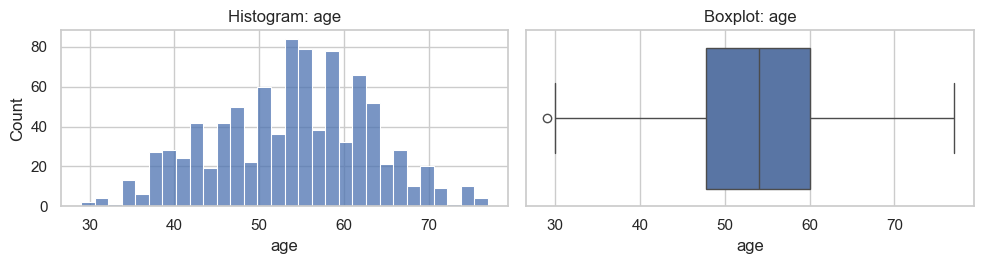

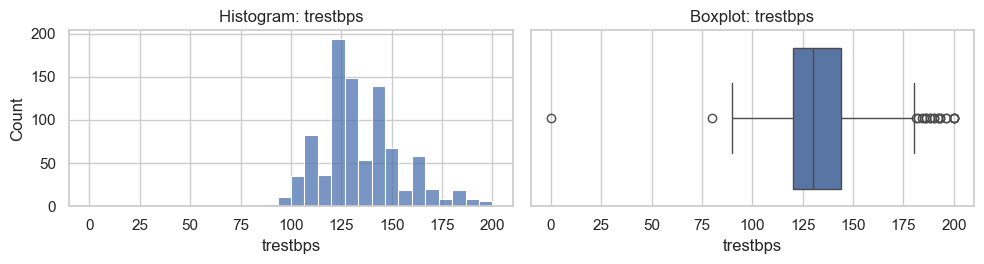

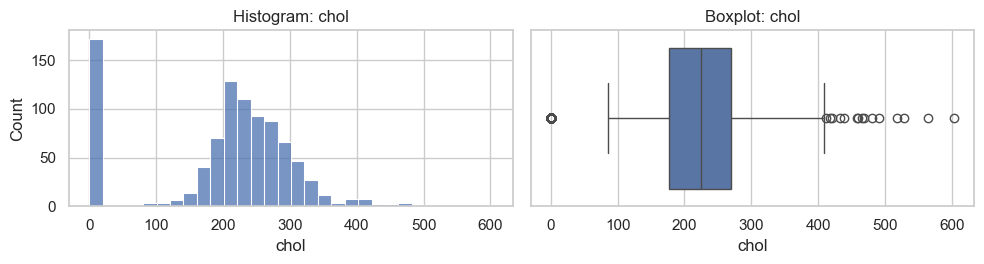

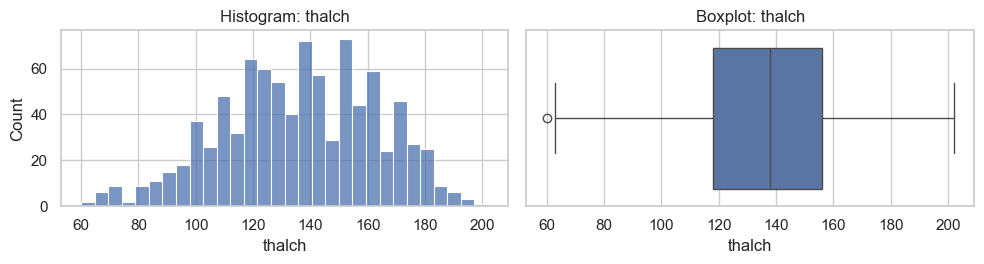

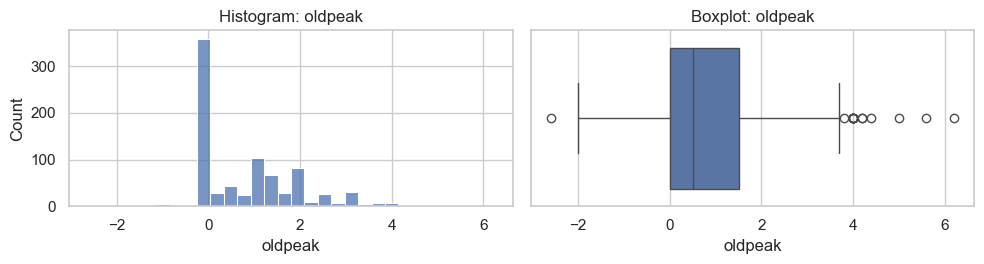

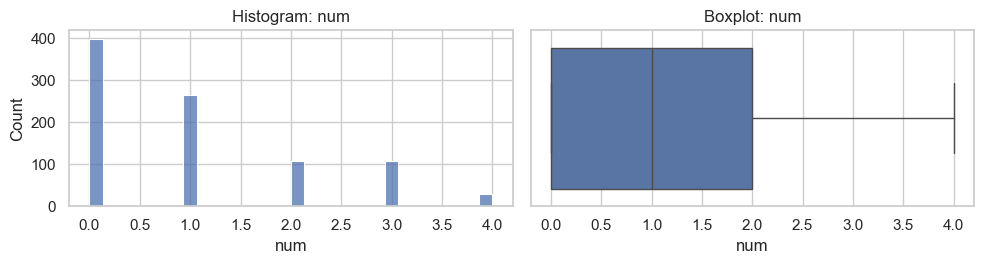

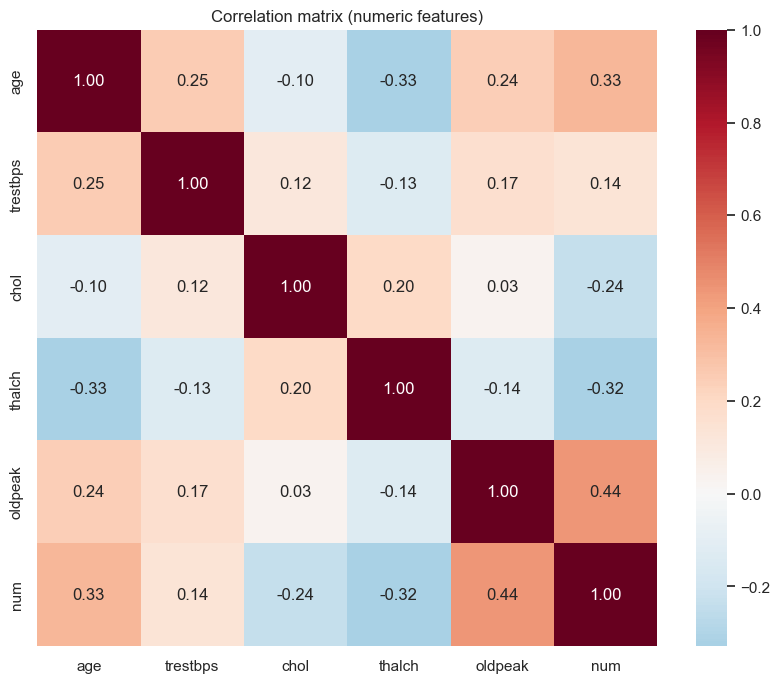

In [2]:
# 2) EDA
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

print("Data types:\n")
display(df.dtypes.to_frame('dtype'))

print("\nMissing values per column:\n")
display(df.isnull().sum().to_frame('missing_count'))

# Numeric columns
num_cols = df.select_dtypes(include=['number']).columns.tolist()
print("Numeric columns:", num_cols)

# Quick histograms and boxplots (subset to avoid long output)
for c in num_cols:
    fig, axes = plt.subplots(1,2, figsize=(10,2.8))
    sns.histplot(df[c].dropna(), bins=30, ax=axes[0])
    axes[0].set_title(f"Histogram: {c}")
    sns.boxplot(x=df[c], ax=axes[1])
    axes[1].set_title(f"Boxplot: {c}")
    plt.tight_layout()
    plt.show()

# Correlation heatmap (numeric only)
plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Correlation matrix (numeric features)")
plt.show()

## 3) Feature Engineering & Preprocessing
Handle missing values, detect the target column robustly, encode categoricals (but exclude the target), and prepare X, y.

In [3]:
# 3) Feature Engineering & Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

df_proc = df.copy()

# Simple missing value handling
for col in df_proc.columns:
    if df_proc[col].dtype == object:
        df_proc[col] = df_proc[col].str.strip().replace('', pd.NA)
        df_proc[col] = df_proc[col].fillna("Missing")
    else:
        df_proc[col] = df_proc[col].fillna(df_proc[col].median())

print("Missing values after simple imputation:")
display(df_proc.isnull().sum().to_frame('missing_count'))

# Robust target detection: look for common names; else ask user (choose last column)
candidates = [c for c in df_proc.columns if c.lower() in ['target','heartdisease','heart_disease','hd','output','diagnosis','class','y','label']]
if len(candidates) == 0:
    target_col = df_proc.columns[-1]
    print("No common target name found; assuming last column is target:", target_col)
else:
    target_col = candidates[0]
    print("Detected target column:", target_col)

# Create X and y, ensuring we don't encode the target
y = df_proc[target_col].copy()
X = df_proc.drop(columns=[target_col]).copy()

print("\nX shape:", X.shape, "y shape:", y.shape)

# Identify categorical columns to encode (exclude numeric-like)
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()
print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# Encoding strategy: One-Hot for <5 categories, Label for >=5 categories
onehot_cols = [c for c in cat_cols if X[c].nunique() < 5]
label_cols = [c for c in cat_cols if X[c].nunique() >= 5]
print("One-hot columns (<5 unique):", onehot_cols)
print("Label-encode columns (>=5 unique):", label_cols)

# Apply one-hot encoding (drop_first=False to keep interpretability)
if onehot_cols:
    X = pd.get_dummies(X, columns=onehot_cols, drop_first=True, prefix_sep='__')

# Label encode others
le = LabelEncoder()
for c in label_cols:
    if c in X.columns:
        X[c] = le.fit_transform(X[c].astype(str))

print("\nFeature matrix shape after encoding:", X.shape)

Missing values after simple imputation:


,missing_count
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalch,0
exang,0
oldpeak,0


No common target name found; assuming last column is target: num

X shape: (908, 12) y shape: (908,)
Categorical columns: ['sex', 'cp', 'restecg', 'exang', 'slope', 'thal']
Numeric columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
One-hot columns (<5 unique): ['sex', 'cp', 'restecg', 'exang', 'slope', 'thal']
Label-encode columns (>=5 unique): []

Feature matrix shape after encoding: (908, 18)


## 4) Baseline Decision Tree Model
Split dataset (80-20), train a baseline Decision Tree, and evaluate with classification metrics. This gives a starting point before tuning.

In [4]:
# 4) Baseline Decision Tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Encode target if needed
if y.dtype == object or y.dtype.name == 'category':
    y_enc = y.astype('category').cat.codes
else:
    y_enc = y.copy()

# Split (use stratify if classification)
stratify_arg = y_enc if (hasattr(y_enc, 'nunique') and y_enc.nunique() > 1) else None
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=stratify_arg)

print("Train/test shapes:", X_train.shape, X_test.shape)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("\nClassification report (baseline):")
print(classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion matrix:")
display(confusion_matrix(y_test, y_pred))

Train/test shapes: (726, 18) (182, 18)

Classification report (baseline):
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        80
           1       0.43      0.40      0.41        53
           2       0.17      0.14      0.15        22
           3       0.10      0.10      0.10        21
           4       0.00      0.00      0.00         6

    accuracy                           0.47       182
   macro avg       0.29      0.27      0.28       182
weighted avg       0.48      0.47      0.47       182


Confusion matrix:


array([[59, 13,  4,  4,  0],
       [11, 21,  8,  7,  6],
       [ 5,  4,  3,  7,  3],
       [ 3, 10,  1,  2,  5],
       [ 2,  1,  2,  1,  0]])

## 5) Hyperparameter Tuning (improved)
Use GridSearchCV with `f1_macro` scoring, include `class_weight='balanced'` option, and extend the search grid. This addresses class imbalance and uses a metric that penalizes poor per-class performance.

In [5]:
# 5) Improved hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [3,5,7,9,12,None],
    'min_samples_split': [2,5,10,20],
    'min_samples_leaf': [1,2,4,8],
    'criterion': ['gini','entropy'],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_dt = grid.best_estimator_

# Evaluate best estimator
y_pred_best = best_dt.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
print("\nClassification report (best_dt):")
print(classification_report(y_test, y_pred_best, zero_division=0))
print("\nConfusion matrix:")
display(confusion_matrix(y_test, y_pred_best))
print('\nF1 macro:', f1_score(y_test, y_pred_best, average="macro", zero_division=0))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred_best))

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 2}

Classification report (best_dt):
              precision    recall  f1-score   support

           0       0.80      0.51      0.63        80
           1       0.30      0.32      0.31        53
           2       0.11      0.14      0.12        22
           3       0.23      0.38      0.29        21
           4       0.00      0.00      0.00         6

    accuracy                           0.38       182
   macro avg       0.29      0.27      0.27       182
weighted avg       0.48      0.38      0.41       182


Confusion matrix:


array([[41, 20,  9,  6,  4],
       [ 6, 17, 10, 17,  3],
       [ 4, 11,  3,  2,  2],
       [ 0,  6,  5,  8,  2],
       [ 0,  3,  1,  2,  0]])


F1 macro: 0.26815187865569545
Balanced accuracy: 0.2701141468594298


### Optional: Handle severe class imbalance using SMOTE (use only on training data). Install `imbalanced-learn` if missing.

In [6]:
# SMOTE example (apply only to training data)
try:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    print("Resampled class distribution:", pd.Series(y_res).value_counts())
    # Fit a tree on resampled data
    dt_sm = DecisionTreeClassifier(random_state=42)
    dt_sm.fit(X_res, y_res)
    y_pred_sm = dt_sm.predict(X_test)
    from sklearn.metrics import classification_report
    print("\nClassification report (SMOTE-trained):")
    print(classification_report(y_test, y_pred_sm, zero_division=0))
except Exception as e:
    print('SMOTE not available or failed:', e)

Resampled class distribution: num
0    319
1    319
2    319
3    319
4    319
Name: count, dtype: int64

Classification report (SMOTE-trained):
              precision    recall  f1-score   support

           0       0.70      0.65      0.68        80
           1       0.31      0.26      0.29        53
           2       0.12      0.14      0.13        22
           3       0.25      0.38      0.30        21
           4       0.00      0.00      0.00         6

    accuracy                           0.42       182
   macro avg       0.28      0.29      0.28       182
weighted avg       0.44      0.42      0.43       182



## 6) Model Interpretation & Saving
Show feature importances, plot a shallow version of the tree, and save the best model + processed data to your working folder.

,importance
thalch,0.186310
age,0.178931
oldpeak,0.150501
chol,0.130134
trestbps,0.079560
cp__atypical angina,0.051111
fbs,0.050096
sex__Male,0.038284
thal__reversable defect,0.027281
slope__upsloping,0.027083


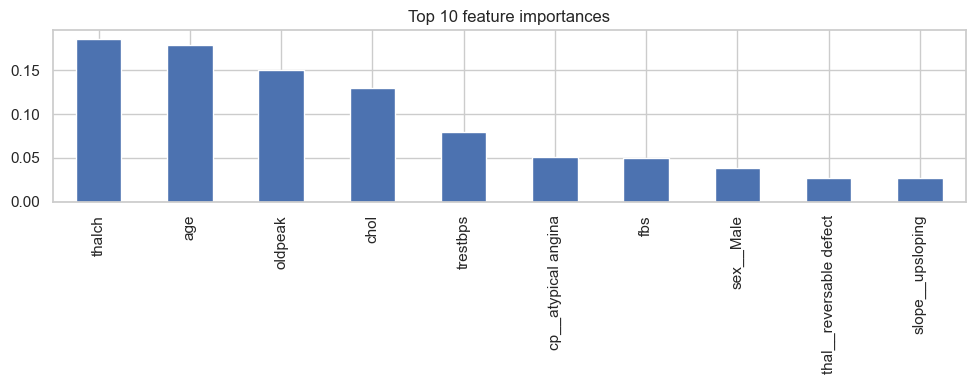

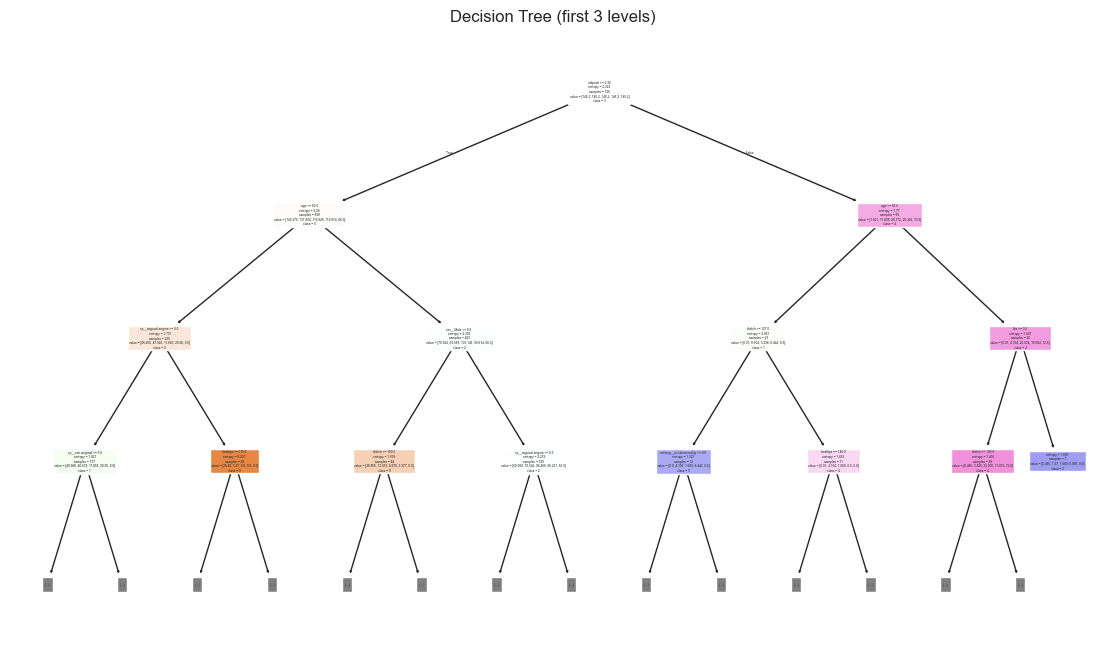

Saved model and processed data to: D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree


In [7]:
# 6) Interpretation & saving
import matplotlib.pyplot as plt, numpy as np, joblib

# Feature importances
feat_imp = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False)
display(feat_imp.head(20).to_frame('importance'))

plt.figure(figsize=(10,4))
feat_imp.head(10).plot(kind='bar')
plt.title('Top 10 feature importances')
plt.tight_layout()
plt.show()

# Plot tree (first 3 levels)
from sklearn import tree
plt.figure(figsize=(14,8))
tree.plot_tree(best_dt, feature_names=X.columns, class_names=[str(c) for c in np.unique(y_enc)], filled=True, max_depth=3)
plt.title('Decision Tree (first 3 levels)')
plt.show()

# Save model and processed data to user's folder
os.makedirs(r"D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree", exist_ok=True)
model_path = os.path.join(r"D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree", "decision_tree_best_model.joblib")
joblib.dump(best_dt, model_path)
X.to_csv(os.path.join(r"D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree", "decision_tree_processed_X.csv"), index=False)
y_enc.to_csv(os.path.join(r"D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree", "decision_tree_processed_y.csv"), index=False)
print("Saved model and processed data to:", r"D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree")

## 7) Interview Questions — Answers

**1. Common hyperparameters of decision tree models, and how they affect performance:**

- `max_depth`: Maximum depth of the tree. Lower values reduce overfitting but may increase bias. Higher values allow more complex rules but can overfit.
- `min_samples_split`: Minimum number of samples required to split an internal node. Larger values make the tree more conservative.
- `min_samples_leaf`: Minimum number of samples required to be at a leaf node. Prevents tiny leaves and overfitting.
- `criterion`: Function to measure split quality (`gini` or `entropy`). Can slightly change tree shape.
- `class_weight`: Adjusts weights for classes to handle imbalance.

**2. Difference between Label Encoding and One-Hot Encoding:**

- **Label Encoding:** Maps categories to integer labels. Compact but introduces ordinal relationships. Good for tree-based models but risky for linear/distance models.
- **One-Hot Encoding:** Creates binary indicator columns. Preserves non-ordinal nature but increases dimensionality, problematic for high-cardinality features.
